## This notebook will implement number of experiments on the normal and anomaly data using Kolmogorov-Smirnov Test (KS Test)

Datasets:

| **Normal** | **Anomaly**                                                    |
|------------|----------------------------------------------------------------|
| building   | laser_fault/building                                           |
| cans       | laser_fault/cans, obstacle/cans                                |
| corr       | laser_fault/corr, obstacle/corr                                |
| pick       | pick/miss_cup, pick/restricted_vision, pick/stolen, pick/stuck |
| -          | software_fault                                                 |
| -          | velocity_attack                                                |

Cans - map name
Corr - map name

In [472]:
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from sklearn.metrics import roc_curve
import pandas as pd

In the first experiment, we will test anomaly detection on building navigation. The normal data contains regular navigation in the environment. The anomaly contains various navigation scenarios and problems while navigation like obstacles, faults of the components, etc.

In [473]:
# Consts
INF=0
SUP=200
TOTAL_ACC = 0.0
EXP_NUM = 0

AUROCs = []

In [474]:
columns = []
def load_directory(directory, file_prefix):
    runs = []
    for i in range(len(os.listdir(directory))):
        f = os.path.join(directory, file_prefix + str(i + 1) + ".csv")
        if os.path.isfile(f):
            runs.append(np.genfromtxt(f, delimiter=",", skip_header=1))
            columns.extend(np.genfromtxt(f, dtype=str, delimiter=",")[0])
    return runs, np.concatenate([np.reshape(r, -1) for r in runs])

def plot_hist(runs, title):
    fig, axs = plt.subplots(1)
    for i, r in enumerate(runs):
        axs.hist(np.reshape(r[np.logical_and(r>INF, r<SUP)], -1), bins='auto', density=True)
    axs.set_title(title)
    axs.set_xlim((INF,SUP))
    
def ks_test(runs, more_runs=[]):
    ks_test = []
    if len(more_runs) == 0: # Compare to itself
        for j, rj in enumerate(runs):
            other_runs = np.concatenate([np.reshape(runs[i], -1) for i in range(len(runs)) if i != j])
            ks_test.append(ks_2samp(np.reshape(other_runs, -1), np.reshape(rj, -1)).statistic)
    else: # Compare to other
        n = 2
        # more_runs - it's normal_normal runs
        # runs - it's potentialy anomaly runs
        for j, rj in enumerate(runs):
            rj = rj[len(rj)*(n-2)//3:]
            ks_test.append(ks_2samp(np.reshape(more_runs, -1), np.reshape(rj, -1)).statistic)
    return ks_test

def plot_ks_test_results(norm_norm, norm_anomaly, anomaly_anomaly, title=''):
    plt.title(title)
    plt.hist(ks_normal_normal, bins="auto", density=True, alpha=0.5, label='normal vs normal')
    plt.hist(ks_normal_anomaly, bins="auto", density=True, alpha=0.5, label='anomaly vs normal')
    plt.hist(ks_anomaly_anomaly, bins="auto", density=True, alpha=0.5, label='anomaly vs anomaly')
    plt.legend()
    plt.savefig(title + '.png')
    
def threshold_dist(norm_norm, threshold_percent=0.95):
    sorted_n_n = norm_norm.copy()
    sorted_n_n.sort(reverse=False)
    threshold_index = int(len(sorted_n_n) * threshold_percent)
#     print(sorted_n_n, threshold_index)
    avg_dist = np.min(sorted_n_n[threshold_index:])
    print('Min distance of ' + str((threshold_percent * 100)) + '% confidence level:', avg_dist)
    return avg_dist

def detect_anomalies(norm_anomaly, norm_norm, threshold_percent=0.9, title="ROC"):
    global EXP_NUM
    global TOTAL_ACC
    EXP_NUM += 1
    avg_dist = threshold_dist(norm_norm, threshold_percent)
    count_anom = [1 if i >= avg_dist else 0 for i in norm_anomaly ]
    TOTAL_ACC += sum(count_anom) * 100/len(norm_anomaly)
    print('Total anomalies detected:', sum(count_anom), 'of', len(norm_anomaly), ', accuracy:' + str(sum(count_anom)*100/len(norm_anomaly)) + '%')

    # The x-axis showing 1 – specificity (= false positive fraction = FP/(FP+TN))
    # The y-axis showing sensitivity (= true positive fraction = TP/(TP+FN))
    x = []
    y = []
    nn_copy = norm_norm.copy()
    nn_copy.sort(reverse=True)
    for t in nn_copy:
        true_positive = sum([1 if i >= t else 0 for i in norm_anomaly ])
        true_negative = sum([1 if i < t else 0 for i in norm_norm ])
        false_positive = sum([1 if i >= t else 0 for i in norm_norm ]) 
        false_negative = sum([1 if i < t else 0 for i in norm_anomaly ]) 
        x.append(false_positive/(false_positive + true_negative))
        y.append(true_positive/(true_positive + false_negative))
    
    fig, axs = plt.subplots(1)
    axs.set(xlim=(-0.1, 1.1), ylim=(-0.1, 1.1))
    axs.plot(x, y, marker='o')
    axs.plot(axs.get_xlim(), axs.get_ylim(), ls="--", c=".3")
    axs.set_title(title)
    axs.set_ylabel('True Positive Rate')
    axs.set_xlabel('False Positive Rate')
    plt.show()
    fig.savefig(title + '.png')
    auroc = 0
    for i in range(len(x)-1):
        auroc +=((x[i+1]-x[i]) * (y[i+1]+y[i]))/2
    print('AUROC:', auroc)
    return [title.replace("ROC", ''), auroc]
    

# Laser Fault

## Loading building and laser faults data

```data/normal/building/counts_normal_build*.csv```

```data/anomaly/laser_fault/building/counts_laser_fault_build*.csv```

In [475]:
TITLE_NORMAL = 'Building normal'
TITLE_ANOMALY = 'Building with laser fault'
NORM_COUNTS_PATH = './data/normal/building'
NORM_FILE_PREFIX = 'counts_normal_build'
ANOMALY_COUNTS_PATH = './data/anomaly/laser_fault/building'
ANOM_FILE_PREFIX = 'counts_laser_fault_build'

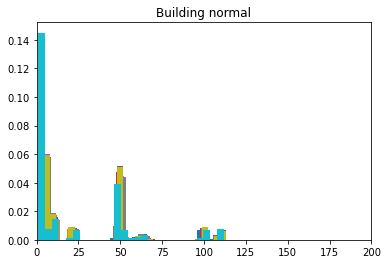

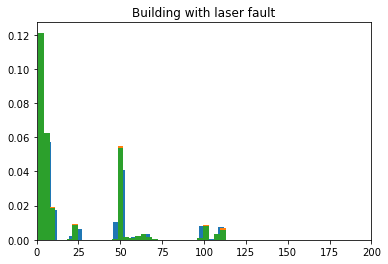

In [476]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Laser fault KS Test

Anomaly Max dist: 0.011147330503300523  Anomaly Min dist:  0.00971543086172355
Min distance of 90.0% confidence level: 0.010434613600547427
Total anomalies detected: 2 of 3 , accuracy:66.66666666666667%


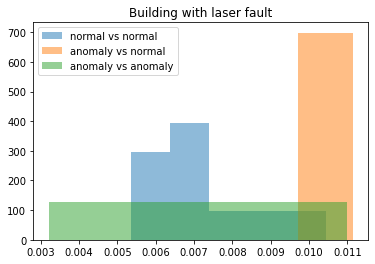

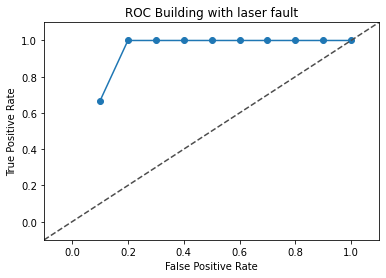

AUROC: 0.8833333333333333


In [477]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

# Software fault

## Loading building and software faults data

```data/normal/building/counts_normal_build*.csv```

```data/anomaly/software_fault/counts_software_fault_*.csv```

In [478]:
TITLE_NORMAL = 'Building normal'
TITLE_ANOMALY = 'Building with software fault'
NORM_COUNTS_PATH = './data/normal/building'
NORM_FILE_PREFIX = 'counts_normal_build'
ANOMALY_COUNTS_PATH = './data/anomaly/software_fault'
ANOM_FILE_PREFIX = 'counts_software_fault_'

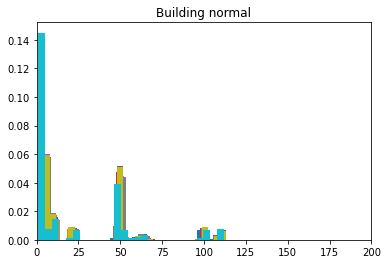

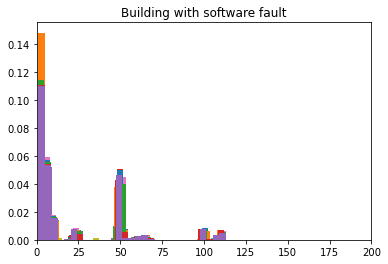

In [479]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)
anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Software fault KS Test

Anomaly Max dist: 0.12254170693457922  Anomaly Min dist:  0.11821770024302602
Min distance of 90.0% confidence level: 0.010434613600547427
Total anomalies detected: 15 of 15 , accuracy:100.0%


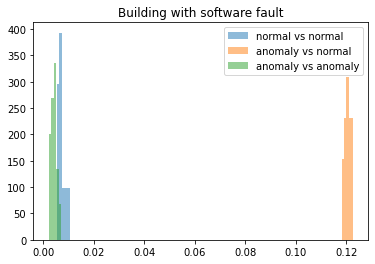

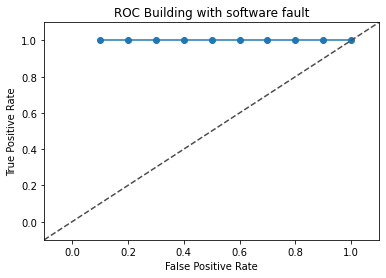

AUROC: 0.9


In [480]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

# Velocity attack

## Loading building and velocity attack data

```data/normal/building/counts_normal_build*.csv```

```data/anomaly/velocity_attack/counts_velocity_attack_*.csv```

In [481]:
TITLE_NORMAL = 'Building normal'
TITLE_ANOMALY = 'Building with velocity attack'
NORM_COUNTS_PATH = './data/normal/building'
NORM_FILE_PREFIX = 'counts_normal_build'
ANOMALY_COUNTS_PATH = './data/anomaly/velocity_attack'
ANOM_FILE_PREFIX = 'counts_velocity_attack_'

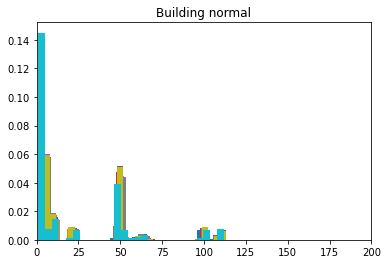

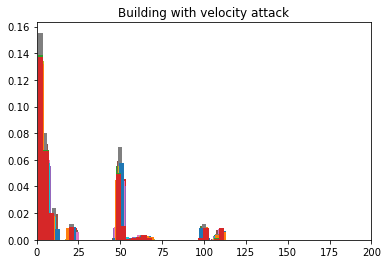

In [482]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Velocity attack KS Test

Anomaly Max dist: 0.12677619541877239  Anomaly Min dist:  0.10410036597411354
Min distance of 90.0% confidence level: 0.010434613600547427
Total anomalies detected: 14 of 14 , accuracy:100.0%


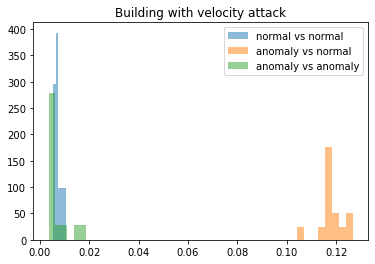

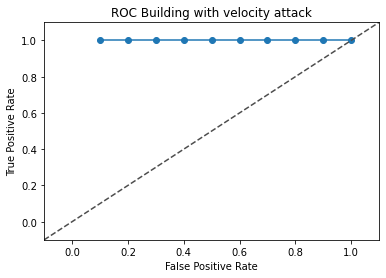

AUROC: 0.9


In [483]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

# Cans Laser fault

## Loading Cans and Laser fault data

```data/normal/cans/counts_normal_cans*.csv```

```data/anomaly/laser_fault/cans/counts_laser_fault_cans*.csv```

In [484]:
TITLE_NORMAL = 'Cans normal'
TITLE_ANOMALY = 'Cans with Laser fault'
NORM_COUNTS_PATH = './data/normal/cans'
NORM_FILE_PREFIX = 'counts_normal_cans'
ANOMALY_COUNTS_PATH = './data/anomaly/laser_fault/cans'
ANOM_FILE_PREFIX = 'counts_laser_fault_cans'

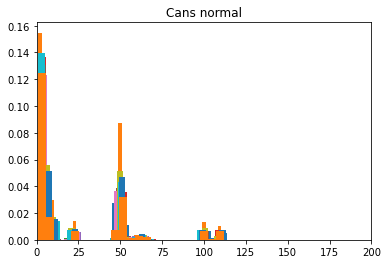

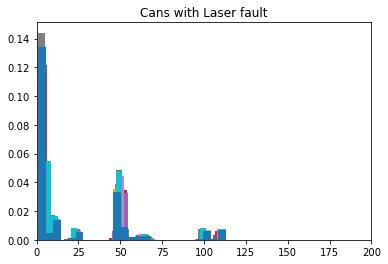

In [485]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Cans Laser fault KS Test

Anomaly Max dist: 0.01547212408495624  Anomaly Min dist:  0.011254595318927807
Min distance of 90.0% confidence level: 0.01650667271774009
Total anomalies detected: 0 of 11 , accuracy:0.0%


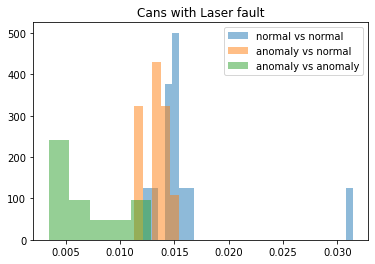

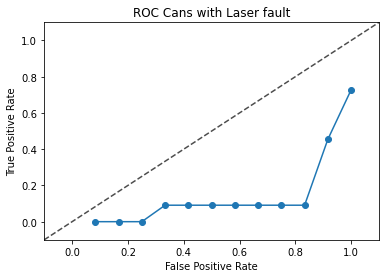

AUROC: 0.12121212121212123


In [486]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

# Cans Obstacles

## Loading Cans and Obstacles data

```data/normal/cans/counts_normal_cans*.csv```

```data/anomaly/obstacle/cans/counts_laser_fault_cans*.csv```

In [487]:
TITLE_NORMAL = 'Cans normal'
TITLE_ANOMALY = 'Cans with Obstacles'
NORM_COUNTS_PATH = './data/normal/cans'
NORM_FILE_PREFIX = 'counts_normal_cans'
ANOMALY_COUNTS_PATH = './data/anomaly/obstacle/cans'
ANOM_FILE_PREFIX = 'counts_obs_cans'

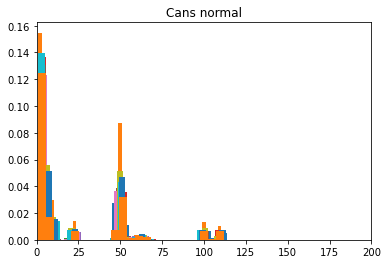

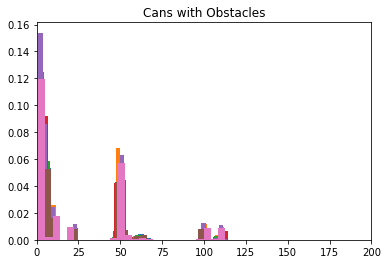

In [488]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Cans Obstacle KS Test

Anomaly Max dist: 0.07574226808919404  Anomaly Min dist:  0.008601005562507535
Min distance of 90.0% confidence level: 0.01650667271774009
Total anomalies detected: 2 of 7 , accuracy:28.571428571428573%


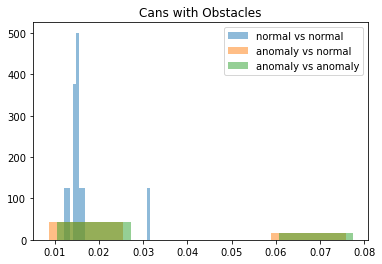

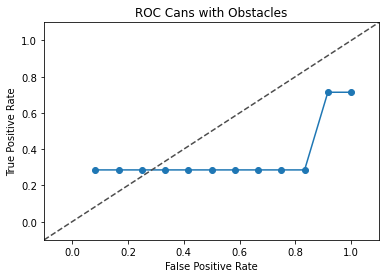

AUROC: 0.3154761904761904


In [489]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

# Corr Laser fault

## Loading Corr and Laser fault data

```data/normal/corr/counts_normal_corr_rand*.csv```

```data/anomaly/laser_fault/corr/counts_laser_fault_corr_rand*.csv```

In [490]:
TITLE_NORMAL = 'Corr normal'
TITLE_ANOMALY = 'Corr with Laser fault'
NORM_COUNTS_PATH = './data/normal/corr'
NORM_FILE_PREFIX = 'counts_normal_corr_rand'
ANOMALY_COUNTS_PATH = './data/anomaly/laser_fault/corr'
ANOM_FILE_PREFIX = 'counts_laser_fault_corr_rand'

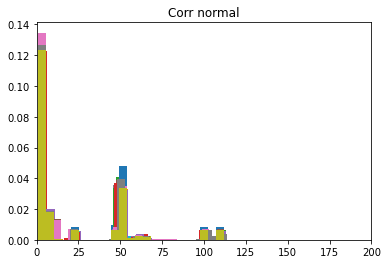

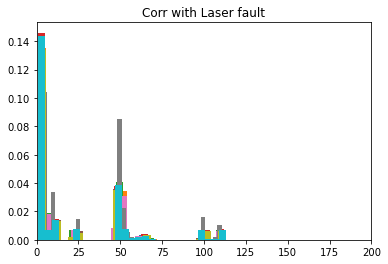

In [491]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Corr Laser fault KS Test

Anomaly Max dist: 0.10626211375320893  Anomaly Min dist:  0.009973020118381748
Min distance of 90.0% confidence level: 0.010120379630341847
Total anomalies detected: 9 of 10 , accuracy:90.0%


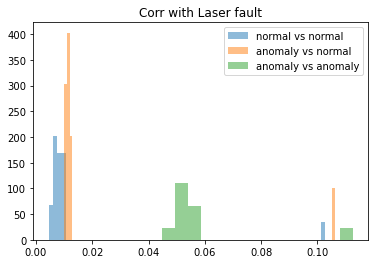

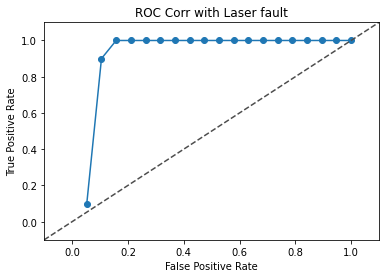

AUROC: 0.918421052631579


In [492]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

# Corr Obstacles

## Loading Corr and Obstacles data

```data/normal/corr/counts_normal_corr_rand*.csv```

```data/anomaly/obstacle/corr/counts_laser_fault_cans*.csv```

In [493]:
TITLE_NORMAL = 'Corr normal'
TITLE_ANOMALY = 'Corr with Obstacles'
NORM_COUNTS_PATH = './data/normal/corr'
NORM_FILE_PREFIX = 'counts_normal_corr_rand'
ANOMALY_COUNTS_PATH = './data/anomaly/obstacle/corr'
ANOM_FILE_PREFIX = 'counts_obs_corr_rand'

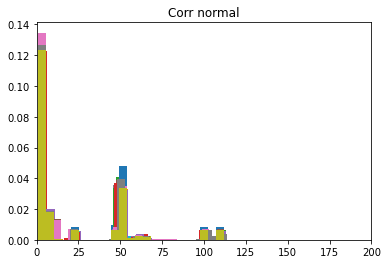

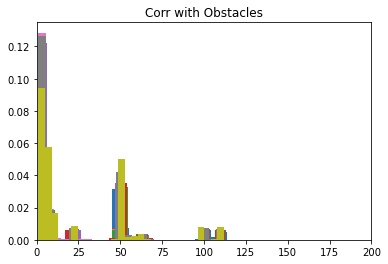

In [494]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Corr Obstacle KS Test

Anomaly Max dist: 0.01893165578613687  Anomaly Min dist:  0.005831608122221499
Min distance of 90.0% confidence level: 0.010120379630341847
Total anomalies detected: 2 of 9 , accuracy:22.22222222222222%


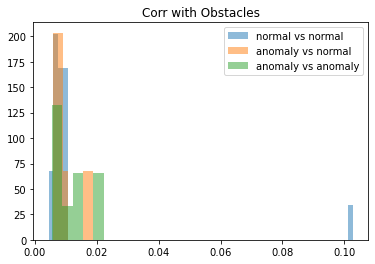

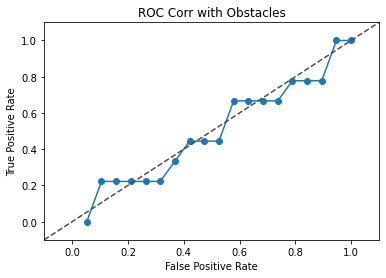

AUROC: 0.48830409356725146


In [495]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

# Pick and miss cup

## Loading pick and miss cup data

```data/normal/pick/pick_normal*.csv```

```data/anomaly/pick/miss_cup/counts_miss_cup*.csv```

In [496]:
TITLE_NORMAL = 'Pick normal'
TITLE_ANOMALY = 'Pick and miss cup'
NORM_COUNTS_PATH = './data/normal/pick'
NORM_FILE_PREFIX = 'pick_normal'
ANOMALY_COUNTS_PATH = './data/anomaly/pick/miss_cup'
ANOM_FILE_PREFIX = 'counts_miss_cup'

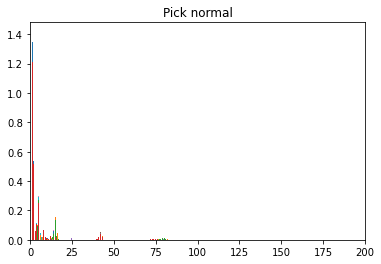

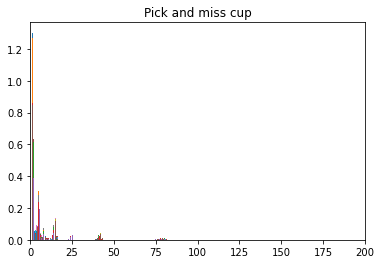

In [497]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Pick and miss cup KS Test

Anomaly Max dist: 0.1123628991367126  Anomaly Min dist:  0.0077835735414824025
Min distance of 90.0% confidence level: 0.05723755163078226
Total anomalies detected: 4 of 16 , accuracy:25.0%


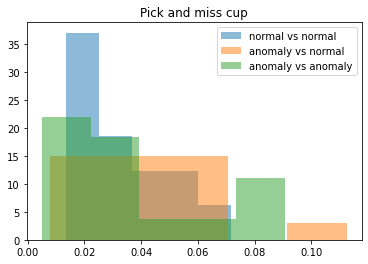

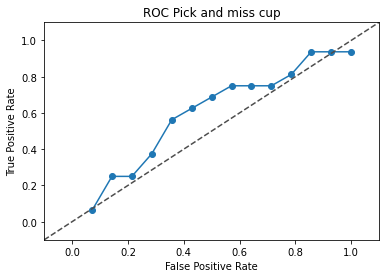

AUROC: 0.5848214285714286


In [498]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

# Pick and restricted vision

## Loading pick and restricted vision data

```data/normal/pick/pick_normal*.csv```

```data/anomaly/pick/restricted_vision/counts_restricted_vision*.csv```

In [499]:
TITLE_NORMAL = 'Pick normal'
TITLE_ANOMALY = 'Pick and restricted vision'
NORM_COUNTS_PATH = './data/normal/pick'
NORM_FILE_PREFIX = 'pick_normal'
ANOMALY_COUNTS_PATH = './data/anomaly/pick/restricted_vision'
ANOM_FILE_PREFIX = 'counts_restricted_vision'

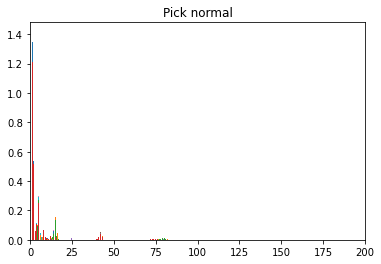

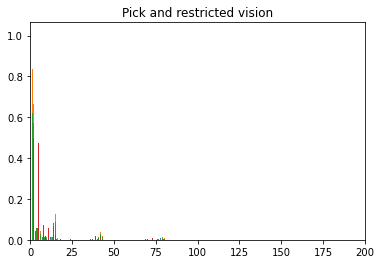

In [500]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Pick and restricted vision KS Test

Anomaly Max dist: 0.37576487062191904  Anomaly Min dist:  0.08387039756656134
Min distance of 90.0% confidence level: 0.05723755163078226
Total anomalies detected: 4 of 4 , accuracy:100.0%


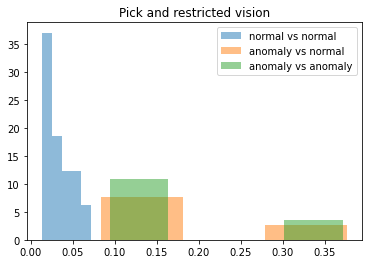

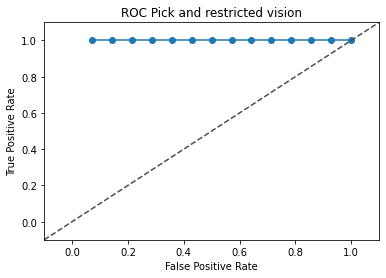

AUROC: 0.9285714285714285


In [501]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

# Pick and stolen cup

## Loading pick and stolen cup data

```data/normal/pick/pick_normal*.csv```

```data/anomaly/pick/stolen/counts_cup_stolen*.csv```

In [502]:
TITLE_NORMAL = 'Pick normal'
TITLE_ANOMALY = 'Pick and stolen'
NORM_COUNTS_PATH = './data/normal/pick'
NORM_FILE_PREFIX = 'pick_normal'
ANOMALY_COUNTS_PATH = './data/anomaly/pick/stolen'
ANOM_FILE_PREFIX = 'counts_cup_stolen'

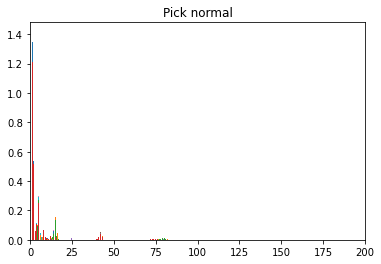

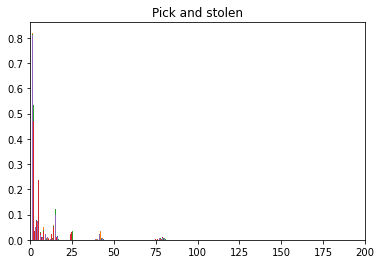

In [503]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Pick and stolen cup KS Test

Anomaly Max dist: 0.08576668266707843  Anomaly Min dist:  0.07159612174274044
Min distance of 90.0% confidence level: 0.05723755163078226
Total anomalies detected: 5 of 5 , accuracy:100.0%


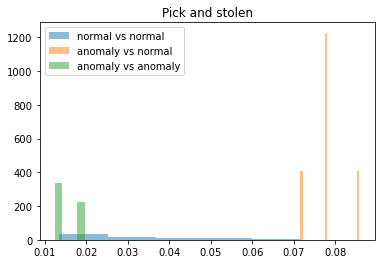

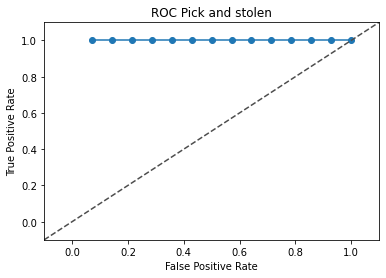

AUROC: 0.9285714285714285


In [504]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

# Pick and stuck

## Loading pick and stuck data

```data/normal/pick/pick_normal*.csv```

```data/anomaly/pick/stuck/counts_got_stuck*.csv```

In [505]:
TITLE_NORMAL = 'Pick normal'
TITLE_ANOMALY = 'Pick and stuck'
NORM_COUNTS_PATH = './data/normal/pick'
NORM_FILE_PREFIX = 'pick_normal'
ANOMALY_COUNTS_PATH = './data/anomaly/pick/stuck'
ANOM_FILE_PREFIX = 'counts_got_stuck'

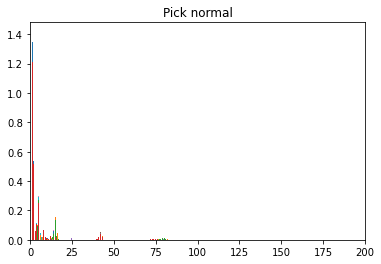

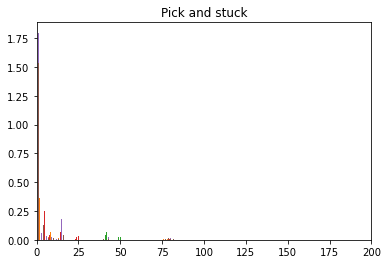

In [506]:
runs, all_runs = load_directory(NORM_COUNTS_PATH, NORM_FILE_PREFIX)
plot_hist(runs, TITLE_NORMAL)

anomaly_runs, all_anomaly_runs = load_directory(ANOMALY_COUNTS_PATH, ANOM_FILE_PREFIX)
plot_hist(anomaly_runs, TITLE_ANOMALY)

### Pick and stuck KS Test

Anomaly Max dist: 0.12130632205820976  Anomaly Min dist:  0.010930770805850143
Min distance of 90.0% confidence level: 0.05723755163078226
Total anomalies detected: 3 of 6 , accuracy:50.0%


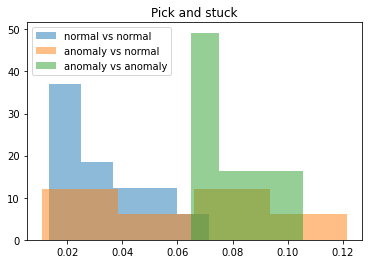

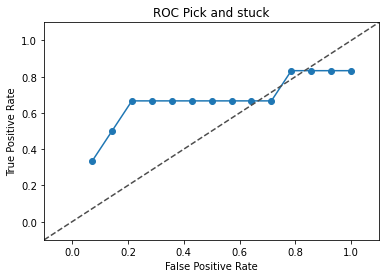

AUROC: 0.6369047619047619


In [507]:
ks_normal_normal = ks_test(runs)
ks_normal_anomaly = ks_test(anomaly_runs, all_runs)
ks_anomaly_anomaly = ks_test(anomaly_runs)
plot_ks_test_results(ks_normal_normal, ks_normal_anomaly, ks_anomaly_anomaly, TITLE_ANOMALY)
print('Anomaly Max dist:', max(ks_normal_anomaly), ' Anomaly Min dist: ', min(ks_normal_anomaly))
auroc = detect_anomalies(norm_anomaly=ks_normal_anomaly, norm_norm=ks_normal_normal, title='ROC ' + TITLE_ANOMALY)
AUROCs.append(auroc)

In [508]:
print('Total Accuracy:', TOTAL_ACC/EXP_NUM)

Total Accuracy: 62.04184704184704


In [509]:
df = pd.DataFrame(AUROCs, columns=['Scenario', 'AUROC'])
df

,Scenario,AUROC
0,Building with laser fault,0.883333
1,Building with software fault,0.900000
2,Building with velocity attack,0.900000
3,Cans with Laser fault,0.121212
4,Cans with Obstacles,0.315476
5,Corr with Laser fault,0.918421
6,Corr with Obstacles,0.488304
7,Pick and miss cup,0.584821
8,Pick and restricted vision,0.928571
9,Pick and stolen,0.928571
